# Voting

En este Notebook pondremos a prueba la potencia de este ensamble para predecir si la instancia tiene alto poder adquisitivo.

Estaremos trabajando sobre los mejores modelos entrenados en los notebooks anteriores para ver con qué nos encontramos si trabajan en conjunto.



In [1]:
# Modelo 
from sklearn.ensemble import VotingClassifier

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing
from preprocessing import preprocessing_base_parte_1, preprocessing_significantes, preprocessing_mejores_por_arbol

# Otros
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import utils


# Métricas
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, plot_confusion_matrix

In [2]:
df = utils.get_data()

## Modelo 1 - Preprocessing base

Utilizaremos para este primer modelo a todos los modelos (cuyas métricas son decentes) entrenados con el preprocessing base, estos serán:

* DecisionTreeClassifier
* KNeighborsClassifier
* SVC
* RandomForest
* BaggingClassifier
* AdaBoost

Veamos qué pasa!

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

In [4]:
m1_dtc = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=11)
m1_knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, p=1, weights='uniform')
m1_svm = SVC(C=100.0, gamma=0.0001, probability=True)
m1_rfc = RandomForestClassifier(n_estimators=1001, criterion='entropy', max_depth=11, max_features=2, n_jobs=-1, random_state=27)
m1_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=12), n_estimators = 501, n_jobs=-1, random_state=27)
m1_abc = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.25, n_estimators = 901, random_state = 27)

m1 = VotingClassifier(estimators=[('dtc', m1_dtc),
                                  ('knn', m1_knn),
                                  ('svm', m1_svm),
                                  ('rfc', m1_rfc),
                                  ('bag', m1_bag),
                                  ('abc', m1_abc)],
                      voting='soft', n_jobs=-1, verbose=4)

In [5]:
m1.fit(X_train_1, y_train_1)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=50)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=30, p=1)),
                             ('svm',
                              SVC(C=100.0, gamma=0.0001, probability=True)),
                             ('rfc',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=11,
                                                     max_features=2,
                                                     n_estimators=1001,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('bag',
                              B

In [6]:
print(classification_report(y_test_1,m1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8698    0.9562    0.9109      6182
           1     0.7985    0.5482    0.6501      1959

    accuracy                         0.8580      8141
   macro avg     0.8341    0.7522    0.7805      8141
weighted avg     0.8526    0.8580    0.8482      8141



Vemos que el modelo está lejos de ser lo esperado, sin embargo se trata de un modelo con un accuracy de 85.8%, número interesante.

Los demás valores son los usuales, poco recall para unos, muchos recalls para ceros. La precision es relativamente alta.

Veamos la matriz de confusión.

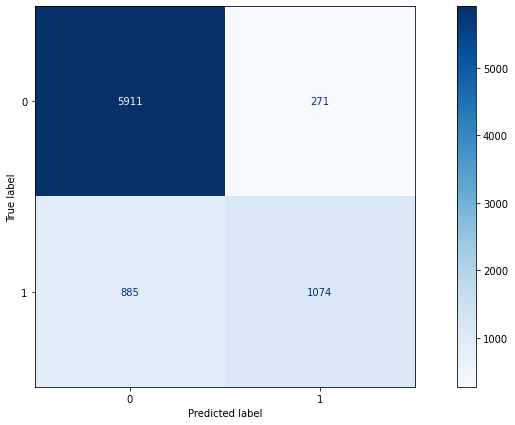

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(m1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

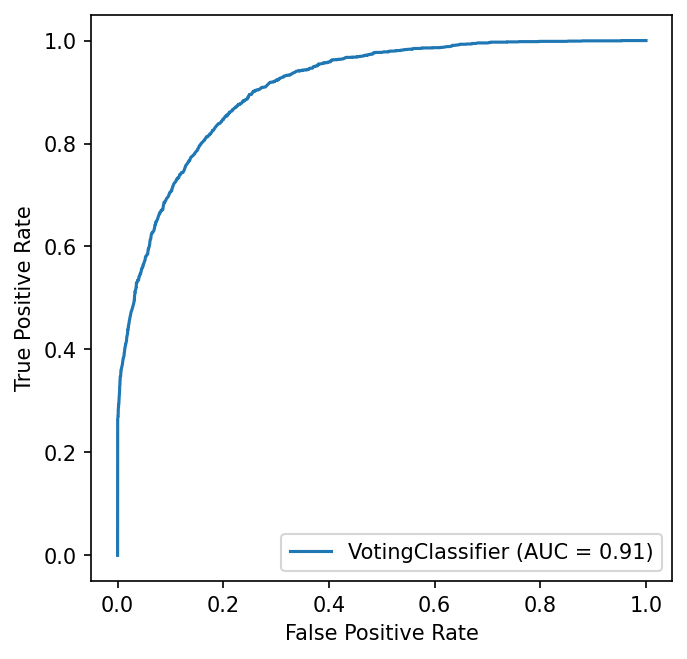

In [8]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(m1, X_test_1, y_test_1, ax=ax)
plt.show()

In [9]:
roc_auc_score(y_test_1, m1.predict_proba(X_test_1)[:, 1])

0.9105915030364464

Vemos que se obtiene un valor de RocAUC bastante alto (si bien, aún así no es más alto que el más alto de los modelos)

## Modelo 2 - Preprocessing Significantes 90%

Utilizaremos para este primer modelo a todos los modelos (cuyas métricas son decentes) entrenados con el preprocessing base, estos serán:

* KNN
* LogisticRegression
* RandomForest

Veamos qué pasa!

In [10]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, 0.9)

/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test[

In [11]:
m2_knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50)
m2_lrc = LogisticRegression(C=0.01, l1_ratio=0.2, penalty='elasticnet', solver='saga')
m2_rfc = RandomForestClassifier(n_estimators=1001,criterion='gini',max_depth=6,oob_score=True,n_jobs=-1,random_state=27)

m2 = VotingClassifier(estimators=[('knn', m2_knn),
                                  ('lrc', m2_lrc),
                                  ('rfc', m2_rfc)],
                                  voting='soft', n_jobs=-1, verbose=4)

In [12]:
m2.fit(X_train_2, y_train_2)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   n_neighbors=50)),
                             ('lrc',
                              LogisticRegression(C=0.01, l1_ratio=0.2,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('rfc',
                              RandomForestClassifier(max_depth=6,
                                                     n_estimators=1001,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=27))],
                 n_jobs=-1, verbose=4, voting='soft')

In [13]:
print(classification_report(y_test_2, m2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.8632    0.9317    0.8961      6182
           1     0.7125    0.5339    0.6104      1959

    accuracy                         0.8360      8141
   macro avg     0.7879    0.7328    0.7533      8141
weighted avg     0.8269    0.8360    0.8274      8141



Vemos que nuevamente no es lo que esperábamos para Voting. Un accuracy de 83.6%, bastante similar (incluso peor) que los modelos estándar.

Veamos las otras métricas.

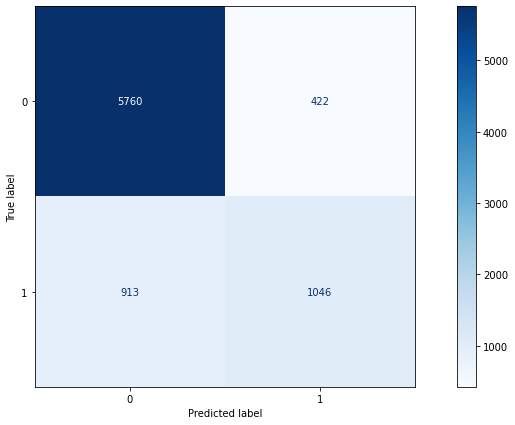

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(m2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

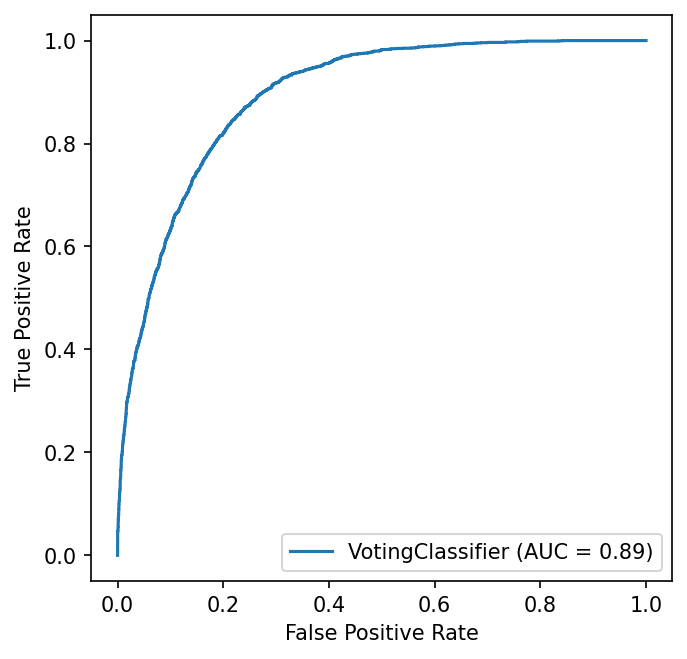

In [15]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(m2, X_test_2, y_test_2, ax=ax)
plt.show()

In [16]:
roc_auc_score(y_test_2, m2.predict_proba(X_test_2)[:, 1])

0.8934396638695984

Vemos que, si bien no deja de ser un resultado aceptable, no está entre los mejores que obtuvimos y es superado por el primer Voting que entrenamos.

# Predicción de HoldOut

Usaremos para predecir el Voting obtenido para el preprocessing Base.

In [18]:
def holdout():
    ids, X = utils.get_holdout_data()    
    X, _ = preprocessing_base_parte_1(X, X)
    return ids, X

In [19]:
ids, X = holdout()

In [20]:
utils.escribir_holdout(m1.predict(X), "11 - Voting", ids)